In [547]:
import numpy as np
import serial, time
import matplotlib.pyplot as plt
from IPython import display
import datetime
%matplotlib inline
import pandas as pd
import openpyxl

In [562]:
def open_serial(port, baudrate=None):
    if baudrate == None:
        try:
            return serial.Serial(port)
        except Exception as e:
            print(e)
            return None
    else:
        try:
            return serial.Serial(port, baudrate)
        except Exception as e:
            print(e)
            return None
        
def close_serial(*devices):
    for device in devices:
        try:
            device.close()
        except Exception as e:
            print(e)

def turn_curtain(curtain_device, angle, TEST = False):
    if TEST:
        # заглушка для тестирования
        print(f'the curtain turned at an {angle}')
    else:
        try:
            command = str(angle)
            curtain_device.write(command.encode('utf-8'))
        except Exception as e:
            print(e)

def d_action(d_device, TEST = False):
    if TEST:
        # заглушка для тестирования
        print('d action')
    else:
        try:
            values = bytes.fromhex('111140014400000000001111400153000A0000001111400150004600000011114001470000000000')
            d_device.write(values)
        except Exception as e:
            print(e)

def read_counts(counter_device, TEST = False):
    if TEST:
        # заглушка для тестирования
        return np.random.randint(low=0, high=100, size=3)
    else:
        try:
            counter_device.reset_input_buffer()
            raw_reading = counter_device.readline().decode(errors='ignore')
            return [int(part.strip()) for part in raw_reading.split('\t')] 
        except Exception as e:
            print(e)
            return None
        
def read_power(powermeter_device, TEST=False):
    if TEST:
        # заглушка для тестирования
        return float(np.random.random())
    else:
        try:
            powermeter_device.write(b'*CVU')
            return float(powermeter_device.readline().decode().strip())
        except Exception as e:
            print(e)

In [551]:
close_serial(s, d, curtain, maestro)

In [552]:
s = open_serial('COM8', 115200)
curtain = open_serial('COM4', 9600)
d = open_serial('COM11')
maestro = open_serial('COM5', 115200)

In [687]:
turn_curtain(curtain, 90)

In [693]:
print(read_counts(s))

[958, 1007, 30]


complete 98.18181818181819 %


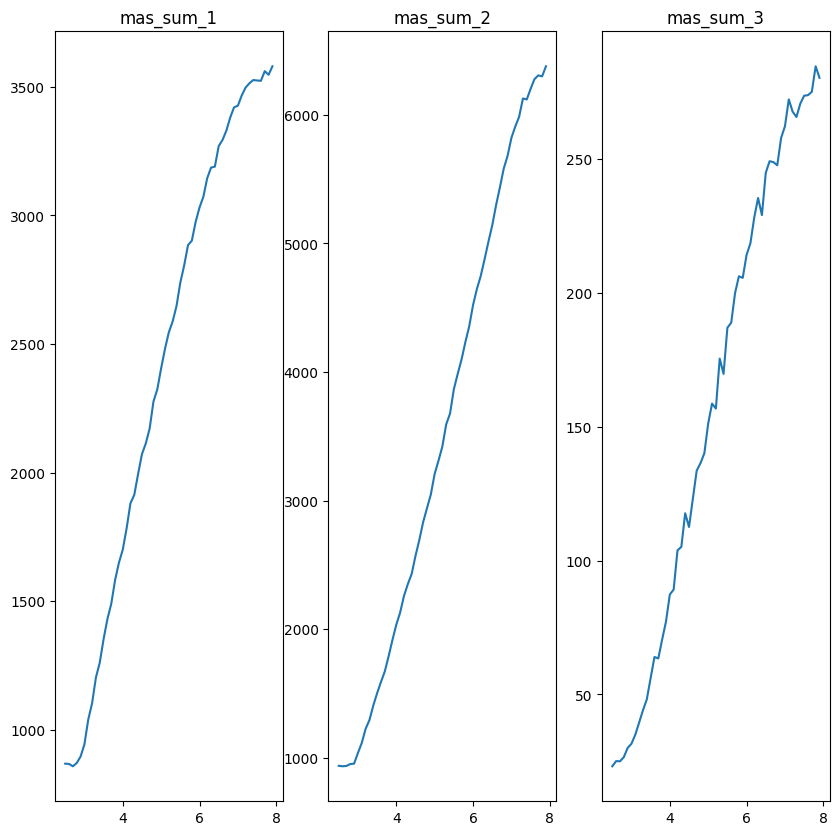

In [694]:
length = 12 # количество усреднений

FLAG = False # в режиме тестирования

data = pd.DataFrame(columns=['diaphragm',
                             'mas_sum_1', 'noise_1',
                             'mas_sum_2', 'noise_2',
                             'mas_sum_3', 'noise_3',
                             'power_abs', 'power_rel',
                             'init_power'])

for i in range(55): 

    data.loc[i, 'diaphragm'] = 2.5 + 0.1 * i

    # измерение шумов

    turn_curtain(curtain, 90)
    time.sleep(6)

    noise_counts = np.zeros(3, dtype=int)
    for j in range(length):
        noise_counts = noise_counts + read_counts(s)
    noise_counts = noise_counts / length
    data.loc[i, ['noise_1', 'noise_2', 'noise_3']] = noise_counts

    print('noise counts', noise_counts, 'length', noise_counts * length)

    # измерение счетов

    turn_curtain(curtain, 0)
    time.sleep(6)

    if i == 0:
        init_power = 0
        for _ in range(length):
            init_power = init_power + read_power(maestro, TEST=FLAG)
        init_power = init_power / length
    
    abs_power = 0 
    true_counts = np.zeros(3, dtype=int)
    for j in range(length):
        true_counts = true_counts + read_counts(s)
        abs_power = abs_power + read_power(maestro, TEST=FLAG)
    true_counts = true_counts / length
    abs_power = abs_power / length

    print('dif', true_counts - noise_counts)

    true_counts = (true_counts - noise_counts) / ( abs_power / init_power )

    print('true', true_counts, 'length', true_counts * length)

    data.loc[i, ['mas_sum_1', 'mas_sum_2', 'mas_sum_3']] = true_counts
    data.loc[i, ['power_abs', 'power_rel']] = abs_power, ( abs_power / init_power )
    data.loc[i, ['init_power']] = init_power

    # построение графиков

    display.clear_output(wait=True)

    fig, axs = plt.subplots(1, 3, figsize=(10, 10))

    for j in range(1, 4):
       ax = axs[j-1]
       ax.plot(data['diaphragm'], data[f'mas_sum_{j}'])
       ax.set_title(f'mas_sum_{j}')

    print("complete {} %".format(100 * i / 55))

    plt.show()
        
    d_action(d, TEST=FLAG)

now = datetime.datetime.now()
filename = 'DWN_result_{}.xlsx'.format(now.strftime('%Y-%m-%d_%H-%M-%S'))
data.to_excel(filename, index=False)

In [679]:
now = datetime.datetime.now()
filename = 'DWN_result_{}.xlsx'.format(now.strftime('%Y-%m-%d_%H-%M-%S'))
data.to_excel(filename, index=False)

In [164]:
turn_curtain(curtain, 90)

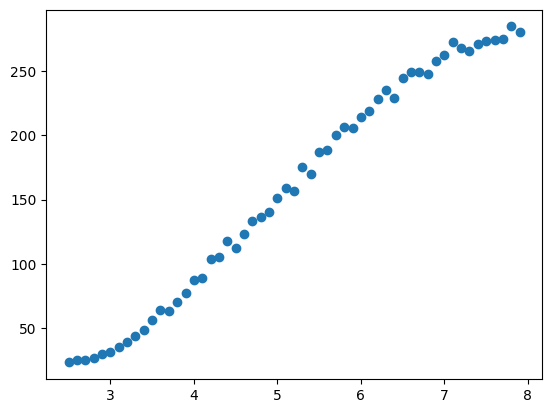

In [695]:
plt.scatter(data['diaphragm'], data['mas_sum_3'])